<a id="top"></a>

# Correlation constrained regression

- [Simulated data](#simulated)
    - [Regression and data models](#regression_models)
    - [Simulated data](#simulated)
    - [Illustrate ADC in simulated data](#adc_simulated)
- [GitHub Readme file](#github_readme)
- [PAC2019 competition data](#pac2019)
    - [Load and combine PAC2019 data](#load_and_combine)
    - [Train regression models](#train_regression)    
    - [PAC2019 results](#results_pac2019)
    - [ADC-MAE tradeoff](#results_tradeoff)
- [Other/old stuff](#other)
    - [Statsmodels](#statsmodels)
    - [Check derivation for inequality constraint](#calc_inequality)
    - [Iris example data](#iris_example)


In [1]:
import scipy, sys, time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn, sklearn.datasets

from numpy.linalg import inv
import scipy
from scipy.spatial.distance import pdist, squareform

sys.path.append('/Users/matthiastreder/mt03/python_tools')
import file_tools as ft

In [2]:
import correlation_constrained_regression as ccr

# If you need to reload packages...
from importlib import reload  # Python 3.4+ only.
reload(ccr)

<module 'correlation_constrained_regression' from '/Users/matthiastreder/git/correlation-constrained-regression/correlation_constrained_regression.py'>

<a id="simulated"></a>
# Simulated data
[back to top](#top)

<a id="regression_models"></a>
### Regression models
[back to top](#top)

In [184]:
def I(n):
    '''Identity matrix for ridge regularization with intercept (element (0,0) has to be 0 not 1)'''
    i = np.eye(n)
    i[0,0] = 0
    return i

In [185]:
def rbf_kernel(X, gamma=1):
    '''Evaluates the RBF kernel for all pairs of rows in X'''
    return np.exp(-gamma * squareform(pdist(X.T, 'sqeuclidean')));

In [186]:
def OLS_solution(y, X):
    '''Given responses y and predictor matrix X, calculates 
    the the predictions :yhat:, :beta:, and hat matrix :H: for
    the OLS model
    '''
    H = X @ inv(X.T@X) @ X.T 
    beta = inv(X.T@X) @ X.T @ y
    yhat = H@y
    return yhat, beta, H

def ridge_solution(y, X, l=1, use_intercept=False):
    '''Given responses y, predictor matrix X, and 
    regularization value l, calculates 
    the the predictions :yhat:, :beta:, and hat matrix :H:
    for the ridge model
    '''
    I = l*np.eye(X.shape[1])
    if use_intercept: I[0,0] = 0
    H = X @ inv(X.T@X + l*I) @ X.T 
    beta = inv(X.T@X + l*I) @ X.T @ y
    yhat = H@y
    return yhat, beta, H

def kernel_ridge_solution(y, X, l=1, gamma=1):
    '''Given responses y, predictor matrix X, and 
    regularization value l, and gamma parameter
    calculate the kernel ridge solution for the RBF kernel
    '''
    K = rbf_kernel(X.T, gamma)
    H = K @ inv(K + l*np.eye(X.shape[0]))
    yhat = H @ y
    return yhat, K, H

In [187]:
def simulate_OLS_data(N=50, sigma=5, noise_type=np.random.normal):
    '''Simulates regression data using the generative model 
    y = b0 + x1*b1 + x2*b2 + sigma * eps
    
    x1,x2 are drawn from a uniform distribution
    b0,b1,b2 are fixed beta coefficients
    eps is N(0,1) normally distributed noise
    
    Arguments:
    N       - number of data points
    sigma   - standard deviation of eps
    noise_type - set to np.random.uniform to have uniform not normal noise
    '''

    # simulate two predictors
    X = np.random.uniform(size=(N,2))
    X = sm.add_constant(X)

    # simulate ground truth beta's
    true_beta = np.array([20, 30, 30])  # this assures the resultant data is boxed in between 20-80

    # simulate ages for different noise levels
    noise = noise_type(0, 1, N)
    if isinstance(sigma, (list,tuple)):
        y = [X @ true_beta + sigma*noise for sigma in sigmas] 
    else:
        y = X @ true_beta + sigma*noise

    return y, X, noise

In [188]:
def simulate_predictor_noise_data(N=50, sigma=5, noise_type=np.random.normal):
    '''Simulates regression data but assumes noise on X (not on y)
    y = b0 + x1*b1 + x2*b2
    but only noisy x + eps is observed
    
    x1,x2 are drawn from a uniform distribution
    b0,b1,b2 are fixed beta coefficients
    eps is N(0,1) normally distributed noise
    
    Arguments:
    N       - number of data points
    sigma   - standard deviation of eps
    noise_type - set to np.random.uniform to have uniform not normal noise
    '''

    # simulate two predictors
    X = np.random.uniform(size=(N,2))

    # simulate ground truth beta's
    true_beta = np.array([20, 30, 30])  # this assures the resultant data is boxed in between 20-80

    # simulate ages for different noise levels
    noise = noise_type(0, 1, 2*N).reshape(N,2)
    y = X @ true_beta[1:] + true_beta[0]
    if isinstance(sigma, (list,tuple)):
        X0 = [X + sigma*noise for sigma in sigmas] 
    else:
        X0 = X + sigma*noise

    return y, X0, noise

In [189]:
def calculate_ADC(y, yhat):
    '''Calculate target-residual correlation (ADC)'''
    return np.corrcoef(y, yhat-y)[0,1]

<a id="adc_simulated"></a>
# Illustrate ADC in simulated data
[back to top](#top)

Illustrate the effect that age-delta correlation (ADC) can have. Here we simulate ages from 20-80 as responses. The true model is a linear regression model with two predictors that are weakly correlated with y. 

We can see that young ages tend to be overpredicted vs elderly tend to be underpredicted.

In [163]:
# generate Gaussian regression data
def generate_gaussian_data(n_samples = 1000, n_features = 1, random_state=42):
    n_informative = np.ceil(n_features / 2)
    X, y, coef = sklearn.datasets.make_regression(n_samples=n_samples, n_features=n_features,
                                          n_informative=1, noise=10, bias = 5, 
                                          coef=True, random_state=random_state)
    return X, y

X, y = generate_gaussian_data()

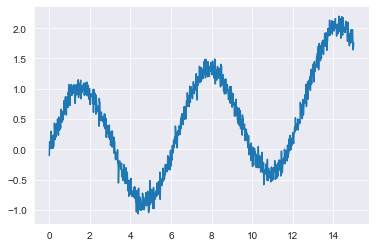

In [164]:
# generate sinusoidal data for kernel ridge
def generate_sinosoidal_data(n_samples = 1000, slope=None, random_state=3):

    np.random.seed(random_state)
    X_sin = np.linspace(0, 15, num=n_samples).reshape(-1,1)
    slope = (np.random.rand()-.5)*.1
    y_sin = (np.sin(X_sin) + slope*X_sin**2 + 0.1*np.random.randn(X_sin.shape[0], 1))[:,0]
    
    return X_sin, y_sin

X_sin, y_sin = generate_sinosoidal_data(slope=0.01)
plt.plot(X_sin, y_sin)

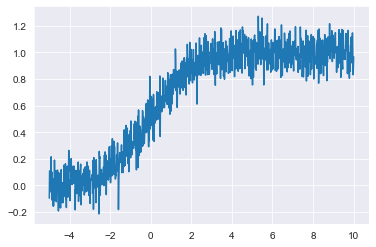

In [165]:
# generate sigmoid data for kernel ridge
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def generate_sigmoid_data(n_samples = 1000, slope=None, random_state=3):

    np.random.seed(random_state)
    X_sigm = np.linspace(-5, 10, num=n_samples).reshape(-1,1)
    slope = (np.random.rand()-.5)*.1
    y_sigm = sigmoid(X_sigm)[:,0] + 0.1*np.random.randn(X_sigm.shape[0], 1)[:,0]
    
    return X_sigm, y_sigm

X_sigm, y_sigm = generate_sigmoid_data(slope=0.01)
plt.plot(X_sigm, y_sigm)

In [166]:
# fit models -- LinearRegression
reg_OLS = sklearn.linear_model.LinearRegression().fit(X, y)
# reg_zero = ccr.LinearRegression(correlation_bound=0).fit(X, y)
# reg_bounded = ccr.LinearRegression(correlation_bound=0.2).fit(X, y)

In [167]:
# fit models -- Ridge
alpha = 1000
reg_Ridge = sklearn.linear_model.Ridge(alpha=alpha).fit(X, y)
# reg_zero = ccr.Ridge(correlation_bound=0, alpha=alpha).fit(X, y)
# reg_bounded = ccr.Ridge(correlation_bound=0.2, alpha=alpha).fit(X, y)

In [168]:
# fit models -- KernelRidge (sinusoidal data)
alpha, kernel = 1, 'rbf'
reg_KR1 = sklearn.kernel_ridge.KernelRidge(alpha=alpha*0.1, kernel=kernel, gamma=1).fit(X_sin, y_sin)
reg_KR2 = sklearn.kernel_ridge.KernelRidge(alpha=alpha*10, kernel=kernel, gamma=1).fit(X_sin, y_sin)
# reg_zero = ccr.KernelRidge(correlation_bound=0, alpha=alpha, kernel=kernel).fit(X_sin, y_sin)
# reg_bounded = ccr.KernelRidge(correlation_bound=0.2, alpha=alpha, kernel=kernel).fit(X_sin, y_sin)

In [169]:
# fit models -- KernelRidge (sigmoid data)
alpha, kernel = 1, 'rbf'
reg_KR1_sigm = sklearn.kernel_ridge.KernelRidge(alpha=alpha*0.1, kernel=kernel, gamma=1).fit(X_sigm, y_sigm)
reg_KR2_sigm = sklearn.kernel_ridge.KernelRidge(alpha=alpha*10, kernel=kernel, gamma=1).fit(X_sigm, y_sigm)

In [170]:
def plot_regression_line_1d(coef, intercept, xl, opt='r-'):
    x = np.array(xl)  
    y = x * coef + intercept
    plt.plot(x, y, opt)

In [171]:
Xvec = np.squeeze(X)
Xvec_sin = np.squeeze(X_sin)
Xvec_sigm = np.squeeze(X_sigm)

deltalab = 'Brain age delta'
xlab = 'Brain data'
ylab = 'Chronological age'

df_OLS = pd.DataFrame({xlab:Xvec, ylab:y, 'yhat':reg_OLS.predict(X), 'Residual': y-reg_OLS.predict(X), deltalab:reg_OLS.predict(X)-y})
df_Ridge = pd.DataFrame({xlab:Xvec, ylab:y, 'yhat':reg_Ridge.predict(X), 'Residual': y-reg_Ridge.predict(X), deltalab:reg_Ridge.predict(X)-y})
df_KR1 = pd.DataFrame({xlab:Xvec_sin, ylab:y_sin, 'yhat':reg_KR1.predict(X_sin), 'Residual': y_sin-reg_KR1.predict(X_sin), deltalab:reg_KR1.predict(X_sin)-y_sin})
df_KR2 = pd.DataFrame({xlab:Xvec_sin, ylab:y_sin, 'yhat':reg_KR2.predict(X_sin), 'Residual': y_sin-reg_KR2.predict(X_sin), deltalab:reg_KR2.predict(X_sin)-y_sin})
df_KR1_sigm = pd.DataFrame({xlab:Xvec_sigm, ylab:y_sigm, 'yhat':reg_KR1_sigm.predict(X_sigm), 'Residual': y_sigm-reg_KR1_sigm.predict(X_sigm), deltalab:reg_KR1_sigm.predict(X_sigm)-y_sigm})
df_KR2_sigm = pd.DataFrame({xlab:Xvec_sigm, ylab:y_sigm, 'yhat':reg_KR2_sigm.predict(X_sigm), 'Residual': y_sigm-reg_KR2_sigm.predict(X_sigm), deltalab:reg_KR2_sigm.predict(X_sigm)-y_sigm})

In [173]:
# visualization settings 

# named colors see : https://matplotlib.org/3.3.2/gallery/color/named_colors.html
col_dots = (.5,.5,.5)
col_xaxis = 'k'

col_OLS = 'darkslateblue'
col_Ridge = 'darkorange'
col_KR1 = 'limegreen'
col_KR2 = 'darkgreen'
# col_KR1 = 'turquoise'
linewidth=3.5

x_res_lab, y_res_lab = 'Age', 'Residual'

scatter_kws = {'color':'slategrey'}
line_kws_OLS = {'color': col_OLS, 'linewidth':linewidth}
# line_kws = {'linewidth':2}
# line_kws = None
line_kws_Ridge = dict(line_kws_OLS)
line_kws_KR1 = dict(line_kws_OLS)
line_kws_KR2 = dict(line_kws_OLS)
line_kws_Ridge['color'] = col_Ridge
line_kws_KR1['color'] = col_KR1
line_kws_KR2['color'] = col_KR2

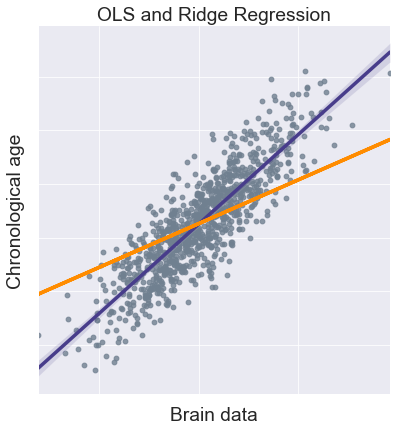

In [174]:
aspect, height = 1, 6

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")
    
    # scatter and OLS
    ax = sns.lmplot(x=xlab, y=ylab, scatter_kws=scatter_kws, line_kws=line_kws_OLS, \
                    data=df_OLS, aspect=aspect, height=height, ci=99)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    
    # plot ridge
    plt.plot(X, reg_Ridge.predict(X), color=line_kws_Ridge['color'], linewidth=line_kws_Ridge['linewidth'])
    plt.title('OLS and Ridge Regression')

#     plt.savefig('Fig1_OLS_Ridge.png', dpi=200)

/Users/matthiastreder/.conda/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  del sys.path[0]


(-50.0, 50.0)


/Users/matthiastreder/.conda/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


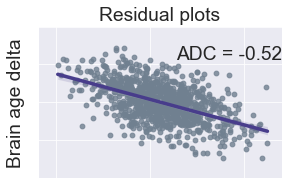

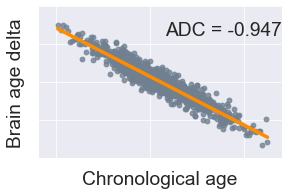

In [175]:
aspect, height = 1.5, 3
xl = [-60, 70]

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")
    
    # OLS
    ax = sns.lmplot(x=ylab, y=deltalab, scatter_kws=scatter_kws, line_kws=line_kws_OLS, \
                    data=df_OLS, aspect=aspect, height=height, ci=99, n_boot=100)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    plt.xlabel('')
    plt.xlim(xl)
    plt.text(plt.xlim()[1], plt.ylim()[1]-10, f'ADC = {calculate_ADC(y, df_OLS["yhat"]):1.2f}', horizontalalignment='right', verticalAlignment='top')
    plt.title('Residual plots')
#     plt.savefig('Fig1_OLS_Ridge_residual1.png', dpi=200)

    # Ridge
    ax = sns.lmplot(x=ylab, y=deltalab, scatter_kws=scatter_kws, line_kws=line_kws_Ridge,  \
                    data=df_Ridge, aspect=aspect, height=height, ci=99)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    plt.xlim(xl)
    plt.text(plt.xlim()[1], plt.ylim()[1]-10, f'ADC = {calculate_ADC(y, df_Ridge["yhat"]):1.3f}', horizontalalignment='right', verticalAlignment='top')
    print(plt.ylim())

#     plt.savefig('Fig1_OLS_Ridge_residual2.png', dpi=200)

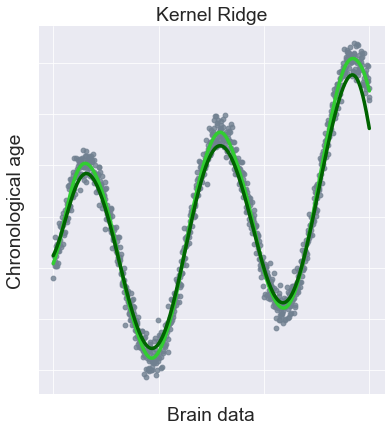

In [176]:
aspect, height = 1, 6

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")
    
    # scatter and OLS
    ax = sns.lmplot(x=xlab, y=ylab, scatter_kws=scatter_kws, fit_reg=False,\
                    data=df_KR1, aspect=aspect, height=height)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    
    # plot ridge
    plt.plot(X_sin, reg_KR1.predict(X_sin), color=col_KR1, linewidth=linewidth)
    plt.plot(X_sin, reg_KR2.predict(X_sin), color=col_KR2, linewidth=linewidth)
    plt.title('Kernel Ridge')

#     plt.savefig('Fig1_KernelRidge.png', dpi=200)

In [ ]:
aspect, height = 1.5, 3
xl = [-1.5, 2.5]

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")
    
    # KR1
    ax = sns.lmplot(x=ylab, y=deltalab, scatter_kws=scatter_kws, line_kws=line_kws_KR1, \
                    data=df_KR1, aspect=aspect, height=height, ci=99, n_boot=100)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    plt.xlabel('')
    plt.xlim(xl)
    plt.ylim([-.5, .5])
    plt.text(plt.xlim()[1], plt.ylim()[1]*.9, f'ADC = {calculate_ADC(y_sin, df_KR1["yhat"]):1.2f}', horizontalalignment='right', verticalAlignment='top')
    plt.title('Residual plots')
#     plt.savefig('Fig1_KernelRidge_residual1.png', dpi=200)

    # KR2
    ax = sns.lmplot(x=ylab, y=deltalab, scatter_kws=scatter_kws, line_kws=line_kws_KR2,  \
                    data=df_KR2, aspect=aspect, height=height, ci=99)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    plt.xlim(xl)
    plt.ylim([-.5, .5])
    plt.text(plt.xlim()[1], plt.ylim()[1]*.9, f'ADC = {calculate_ADC(y_sin, df_KR2["yhat"]):1.3f}', horizontalalignment='right', verticalAlignment='top')
    
#     plt.savefig('Fig1_KernelRidge_residual2.png', dpi=200)

In [ ]:
aspect, height = 1, 6

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")
    
    # scatter and OLS
    ax = sns.lmplot(x=xlab, y=ylab, scatter_kws=scatter_kws, fit_reg=False,\
                    data=df_KR1_sigm, aspect=aspect, height=height)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    
    # plot ridge
    plt.plot(X_sigm, reg_KR1_sigm.predict(X_sigm), color=col_KR1, linewidth=linewidth)
    plt.plot(X_sigm, reg_KR2_sigm.predict(X_sigm), color=col_KR2, linewidth=linewidth)
    plt.title('Kernel Ridge')

    plt.savefig('Fig1_KernelRidge_sigmoid.png', dpi=200)

In [ ]:
aspect, height = 1.5, 3
xl = [-1.5, 2.5]

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")
    
    # KR1
    ax = sns.lmplot(x=ylab, y=deltalab, scatter_kws=scatter_kws, line_kws=line_kws_KR1, \
                    data=df_KR1, aspect=aspect, height=height, ci=99, n_boot=100)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    plt.xlabel('')
    plt.xlim(xl)
    plt.ylim([-.5, .5])
    plt.text(plt.xlim()[1], plt.ylim()[1]*.9, f'ADC = {calculate_ADC(y_sin, df_KR1["yhat"]):1.2f}', horizontalalignment='right', verticalAlignment='top')
    plt.title('Residual plots')
    plt.savefig('Fig1_KernelRidge_residual1_sigmoid.png', dpi=200)

    # KR2
    ax = sns.lmplot(x=ylab, y=deltalab, scatter_kws=scatter_kws, line_kws=line_kws_KR2,  \
                    data=df_KR2, aspect=aspect, height=height, ci=99)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    plt.xlim(xl)
    plt.ylim([-.5, .5])
    plt.text(plt.xlim()[1], plt.ylim()[1]*.9, f'ADC = {calculate_ADC(y_sin, df_KR2["yhat"]):1.3f}', horizontalalignment='right', verticalAlignment='top')
    
    plt.savefig('Fig1_KernelRidge_residual2_sigmoid.png', dpi=200)

In [ ]:
# correlation as a function of ridge lambda
lambda_vals = np.linspace(0, 1000, 20)
ADC = np.zeros((len(lambda_vals), 2))
# kernel ridge for different values of gamma 
for ix, lam in enumerate(lambda_vals):
    # ridge 
    reg_Ridge = sklearn.linear_model.Ridge(alpha=lam).fit(X, y)
    reg_KR1 = sklearn.kernel_ridge.KernelRidge(alpha=lam, kernel=kernel, gamma=1).fit(X, y)
#     reg_KR2 = sklearn.kernel_ridge.KernelRidge(alpha=alpha*0.1, kernel=kernel, gamma=1).fit(X_sin, y_sin)

    ADC[ix, 0] = calculate_ADC(y, reg_Ridge.predict(X))
    ADC[ix, 1] = calculate_ADC(y, reg_KR1.predict(X))
        

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")

    plt.plot(lambda_vals, ADC[:, 0], color=col_Ridge, marker='o',\
             markersize=12, linewidth=linewidth)
    plt.plot(lambda_vals, ADC[:, 1], color=col_KR1, marker='^', \
             markersize=13, linewidth=linewidth)
    plt.title(r'Effect of regularization on ADC')
    plt.xlabel(r'$\lambda$'), plt.ylabel('ADC')

#     plt.savefig('Fig1_ADC_as_function_of_lambda.png', dpi=200)

In [ ]:
# ADC for randomly selected beta and intercept
n = 100
ADC = np.zeros((n, 2))

# random regression coefficients
beta = 2*(np.random.rand(n)-0.5) * 20
intercept = 2*(np.random.rand(n)-0.5) * 10

for ix in range(n):
    
    # generate random data
    X, y = generate_gaussian_data(random_state=ix)
#     X_sin, y_sin = generate_sinosoidal_data(random_state=ix)
    X_sin, y_sin = generate_sigmoid_data(random_state=ix)
    
    # linear regression
    yhat = np.squeeze(X * beta[ix] + intercept[ix]) # gaussian data
    yhat_sin = np.squeeze(X_sin * beta[ix] + intercept[ix]) # sinusoidal data
#     yhat = X * beta[ix] + intercept[ix] # gaussian data
#     yhat_sin = X_sin * beta[ix] + intercept[ix] # sinusoidal data

    ADC[ix, 0] = calculate_ADC(y, yhat)
    ADC[ix, 1] = calculate_ADC(y, yhat_sin)
    
df1 = pd.DataFrame({'ADC':ADC[:,0]})
df2 = pd.DataFrame({'ADC':ADC[:,1]})

df1['dataset'] = 'Gaussian'
# df2['dataset'] = 'Sinusoidal'
df2['dataset'] = 'Sigmoid'

df_ADC = pd.concat((df1, df2), axis=0)
df_ADC['dataset'] = df_ADC['dataset'].astype('category')

pal = sns.color_palette("hls", 5)
# pal = sns.color_palette("husl", 2)
# 

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")

    ax = sns.displot(x='ADC', hue="dataset", kind="kde",rug=False, multiple="stack", linewidth=2, \
                     height=4.5, aspect=1.25, data=df_ADC, legend=False, palette=('palevioletred', 'dodgerblue'))
    ax.set_yticklabels('')
    plt.xlim([-1, 0])
    plt.legend(('Sigmoid', 'Gaussian'))
    plt.title('Distribution of ADC for random models')
    plt.savefig('Fig1_ADC_density.png', dpi=200)

In [ ]:
from sklearn.model_selection import train_test_split
# ADC for randomly selected beta and intercept
n = 100
ADC = np.zeros((n, 2))

# random regression coefficients
beta = 2*(np.random.rand(n)-0.5) * 20
intercept = 2*(np.random.rand(n)-0.5) * 10

for ix in range(n):
    
    # generate random data
    X, y = generate_gaussian_data(n_samples=n, random_state=ix, n_features=5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        
    # linear regression
    model = sklearn.linear_model.LinearRegression().fit(X_train, y_train)
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    ADC[ix, 0] = calculate_ADC(y_train, yhat_train)
    ADC[ix, 1] = calculate_ADC(y_test, yhat_test)
    
df1 = pd.DataFrame({'ADC':ADC[:, 0]})
df2 = pd.DataFrame({'ADC':ADC[:, 1]})

df1['set'] = 'train'
df2['set'] = 'test'

df_ADC = pd.concat((df1, df2), axis=0)
df_ADC['set'] = df_ADC['set'].astype('category')

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")

    ax = sns.displot(x='ADC', hue="set", rug=True, kind="kde", multiple="layer", \
                     height=4.5, aspect=1.25, data=df_ADC, legend=False, \
                    linewidth=6, palette=('gold', 'olive'))
    ax.set_yticklabels('')
    plt.legend(('train', 'test'))


    plt.xlim([-1, 0.4])
#     plt.legend(('Train', 'Test'))
    plt.title('Distribution of ADC for train/test splits')
#     plt.savefig('Fig1_ADC_train_test.png', dpi=200)

<a id="github_readme"></a>
# GitHub Readme file

This is the code pasted in the [Github Readme file](https://github.com/treder/correlation-constrained-regression).

[back to top](#top)

In [ ]:
import numpy as np
import correlation_constrained_regression as ccr

# create some regression data
X = np.array([[1, 1], [1, 2], [3, 2], [3, 3], [4, 3], [4, 4]])
y = np.dot(X, np.array([1, 2])) + np.array([0.1, 0.2, -0.1, -0.2, -0.1, -0.2])

# fit correlation constrained model and calculate residual correlation
reg = ccr.LinearRegression(correlation_bound=0.01).fit(X, y)
print('corr(y, e):', np.corrcoef(y, y - reg.predict(X))[0,1])

# instead of calculating the correlation by hand, we can use the built-in method:
print('corr(y, e):', reg.calculate_residual_correlation(X, y))

# scaling factor
print('theta:', reg.theta_)

# for comparison: let's train a standard linear regression model in Scikit-Learn and print the correlation
reg = sklearn.linear_model.LinearRegression().fit(X, y)
print('corr(y, e):', np.corrcoef(y, y - reg.predict(X))[0,1])

In [ ]:
ridge = ccr.Ridge(correlation_bound=0.1, alpha=10).fit(X, y)
krr = ccr.KernelRidge(correlation_bound=0, kernel='rbf', gamma=1).fit(X, y)
print('corr(y, e):', ridge.calculate_residual_correlation(X, y))
print('corr(y, e):', krr.calculate_residual_correlation(X, y))

In [ ]:
ridge.theta_

In [ ]:
tune_KernelRidge = [
  {'kernel': ['rbf'], 'gamma': [100, 10, 1, 1e-1], 'alpha': [1e-3, 1e-2, 1e-1, 1, 10]},
  {'kernel': ['poly'], 'gamma': [100, 10, 1, 1e-1], 'alpha': [1e-3, 1e-2, 1e-1, 1, 10], 'degree': [2, 3, 4, 5], 'coef0':[0, 1]}
 ]
 
krr = sklearn.model_selection.GridSearchCV(ccr.KernelRidge(correlation_bound=0), param_grid=tune_KernelRidge, scoring='neg_mean_squared_error')

In [ ]:
# Generate some regression data
X, y = sklearn.datasets.make_regression(n_samples=500, n_features=5,
                                          n_informative=1, noise=10, bias = 5, 
                                          coef=False, random_state=42)

# Split into train and test data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)

<a id="pac2019"></a>
# Analyze PAC2019 competition data
[back to top](#top)

<a id="load_and_combine"></a>
##  Load and combine PAC2019 data
[back to top](#top)

Load and combine the following two `csv` files: 

- `pac2019_ICA_20201202.csv`: data from Kamen with IC loadings for both train and test subjects. For the test subjects, the age is missing.
- `PAC2019_BrainAge_Test.csv`: ages for the test data. Data kindly provided by the PAC2019 organizers.

In [6]:
datadir = '/Users/matthiastreder/data/pac2019/'

In [7]:
#df = pd.read_csv('PAC2019_BrainAge_ICA_reduced.csv') # previous file by Kamen don't use

# Kamen's data with IC loadings
df = pd.read_csv(datadir + 'pac2019_ICA_20201202.csv').sort_values(by='subject_ID').set_index('subject_ID')
print(f'Dataset has {df.shape[0]} subjects ({sum(df.holdout==0)} train, {sum(df.holdout)} test)')
df.head()

Dataset has 3300 subjects (2640 train, 660 test)


,age,gender,site,holdout,genderNum,SubID,Age,gmTotal,gmMean,wmTotal,...,loadings_wmUnzip_090,loadings_wmUnzip_091,loadings_wmUnzip_092,loadings_wmUnzip_093,loadings_wmUnzip_094,loadings_wmUnzip_095,loadings_wmUnzip_096,loadings_wmUnzip_097,loadings_wmUnzip_098,loadings_wmUnzip_099
subject_ID,,,,,,,,,,,,,,,,,,,,,
sub0,60.00,f,10,0,1,sub0,60.00,150566.7920,0.414265,104638.95520,...,0.007047,-0.001126,0.000647,0.031964,0.008760,0.005512,0.004223,0.000703,0.005933,0.003607
sub1,26.00,f,0,0,1,sub1,26.00,165577.0218,0.455564,98226.18307,...,0.002583,-0.000388,0.002187,0.026078,0.008748,0.005081,0.003293,0.001148,0.003675,0.001563
sub10,25.00,f,0,0,1,sub10,25.00,174315.0426,0.479606,97569.50699,...,0.004053,0.000608,0.001105,0.026738,0.008045,0.007278,0.004109,0.001657,0.002347,0.001188
sub100,81.00,m,14,0,2,sub100,81.00,135560.2782,0.372977,99499.29654,...,0.002170,0.002590,0.002934,0.026693,0.007530,0.006734,0.004576,0.002898,0.003173,0.000353
sub1000,59.51,m,9,0,2,sub1000,59.51,132073.4203,0.363383,92420.51011,...,0.002530,0.002752,0.000695,0.025964,0.004600,0.004696,0.002718,0.000351,0.000848,0.001363


In [8]:
# Ages for test set
testages = pd.read_csv(datadir + 'PAC2019_BrainAge_Test.csv').sort_values(by='subject_ID')
print(testages.shape)
testages.head()
# Add test ages 

assert np.all(df.loc[testages.subject_ID, 'holdout']==1), 'all testsubjects should be in the holdout set'

(660, 4)


In [9]:
# Insert test ages to df
df.loc[testages.subject_ID,'age'] = testages['age'].to_numpy()

In [10]:
# extract features and age
feature_ix = [ix for ix, name in enumerate(df.columns) if name.startswith('loadings')]
feature_names = df.columns[feature_ix]
X_train = df[df.holdout==0].iloc[:, feature_ix].to_numpy()
X_test = df[df.holdout==1].iloc[:, feature_ix].to_numpy()
y_train = df[df.holdout==0]['age'].to_numpy()
y_test = df[df.holdout==1]['age'].to_numpy()
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (2640, 171) Test: (660, 171)


In [ ]:
# ft.save_pickle('pac2019_ICA_20201202_train_and_test.pickle', X_train, X_test, y_train, y_test, feature_names)

<a id="train_regression"></a>
##  Train regression models
[back to top](#top)

Just define the models here. The actual analysis is performed in `run_regression_analysis.py`.

In [179]:
yr = np.random.randn(*y_train.shape)
start_time = time.time()
c = np.corrcoef(y_train, yr)[0,1]
print(time.time() - start_time)

yr = np.random.randn(*y_train.shape)
start_time = time.time()
yr -= yr.mean()
y_train -= y_train.mean()
c = yr.dot(y_train) / (np.linalg.norm(yr)*np.linalg.norm(y_train))
print(time.time() - start_time)

0.0019659996032714844
0.0004398822784423828


In [180]:
# start_time = time.time()
model = ccr.LinearRegression(correlation_bound=None).fit(X_train, y_train)
print('Unconstrained correlation (train and test):', model.calculate_residual_correlation(X_train, y_train), model.calculate_residual_correlation(X_test, y_test))
# print('Time:', time.time() - start_time)

model = ccr.LinearRegression(correlation_bound=0.05).fit(X_train, y_train)
print('With bound 0.05:', model.calculate_residual_correlation(X_train, y_train), model.calculate_residual_correlation(X_test, y_test))

Unconstrained correlation (train and test): 0.3976582406929805 0.35593679764395453
1.1626095326352504 1.2141789338840088
With bound 0.05: 0.0500000000000002 0.016941116466733967


In [181]:
alpha = 0.1
model = ccr.Ridge(alpha=alpha, correlation_bound=None).fit(X_train, y_train)
print('Unconstrained correlation (train and test):', model.calculate_residual_correlation(X_train, y_train), model.calculate_residual_correlation(X_test, y_test))
# print(model.coef_[:2])
# print(model.theta_)

model = ccr.Ridge(alpha=alpha, correlation_bound=0.05).fit(X_train, y_train)
print('With bound 0.05:', model.calculate_residual_correlation(X_train, y_train), model.calculate_residual_correlation(X_test, y_test))
# print(model.coef_[:2])
# model.theta_

Unconstrained correlation (train and test): 0.9573322097484256 0.9561608404260775
3.4877433300462526 3.7760249664737335
With bound 0.05: 0.0499999999999996 0.06166627127893067


In [195]:
import correlation_constrained_regression as ccr

# If you need to reload packages...
from importlib import reload  # Python 3.4+ only.
reload(ccr)

<module 'correlation_constrained_regression' from '/Users/matthiastreder/git/correlation-constrained-regression/correlation_constrained_regression.py'>

In [196]:
model = ccr.KernelRidge(correlation_bound=None).fit(X_train, y_train)
print('Unconstrained correlation (train and test):', model.calculate_residual_correlation(X_train, y_train), model.calculate_residual_correlation(X_test, y_test))

model = ccr.KernelRidge(correlation_bound=0.05).fit(X_train, y_train)
print('With bound 0.05:', model.calculate_residual_correlation(X_train, y_train), model.calculate_residual_correlation(X_test, y_test))

correlation_bound: None
Unconstrained correlation (train and test): 0.9996656151899489 0.9996822055673432
correlation_bound: 0.05
31.32590024874635 33.99978971675003
With bound 0.05: 0.049999999999999906 0.041889808534011766


<a id="results_pac2019"></a>
# PAC2019 results
[back to top](#top)

Plot results obtained with `run_regression_analysis_train_test.py`.

In [103]:
# data dimensions:
resultsdir = '/Users/matthiastreder/data/pac2019/results/'
# iterations x constraints (unconstrained,zero,bounded) x models (LinReg,ridge,KernelRidge) x Train/Test(Predict) phase
times, mae, corrs = \
ft.load_pickle(resultsdir + 'regression_results_pac2019_train_test.pickle')
# times, mae, corrs = ft.load_pickle(resultsdir + 'regression_results_pac2019.pickle') # old version

In [104]:
# convert ndarray into Pandas dataframes
df_t = []
df_m = []
df_c = []
time_data = ('Train', 'Test')  # that what was timed
constraints = ('Unconstrained', r'$\rho=0$', r'$|\rho|\, ≤\, 0.1$', r'$|\rho|\, ≤\, 0.2$', r'$|\rho|\, ≤\, 0.3$','Approach 1', 'Approach 2')
for cx, constraint in enumerate(constraints):
# for cx, constraint in enumerate(('Unconstrained', r'Zero correlation ($\rho=0$)', r'Bounded correlation ($|\rho|\, ≤\, 0.2$)')):
    for mx, model in enumerate(('OLS', 'Ridge', 'KernelRidge')):
        for px, data in enumerate(('Train', 'Test')):
            
            # remove first iteration from times since it seems to be an outlier
            # (possibly affected by dynamic loading of packages etc)
            tim = times[1:, cx, mx, px]
            
            if model == 'KernelRidge':
                # for TimeMix: we measure KernelRidge time in [s] and the other models in [ms]
                tmp_t = pd.DataFrame({'TimeMix':tim, 'TimeMs':tim*1000, 'Time':tim, 'Log Time':np.log(1+tim)})
            else:
                tmp_t = pd.DataFrame({'TimeMix':tim*1000, 'TimeMs':tim*1000, 'Time':tim, 'Log Time':np.log(1+tim)})
            tmp_m = pd.DataFrame({'MAE':mae[:, cx, mx, px]})
            tmp_c = pd.DataFrame({'ADC':-corrs[:, cx, mx, px]})

            tmp_t['constraint'] = tmp_m['constraint'] = tmp_c['constraint'] = constraint
            tmp_t['model'] = tmp_m['model'] = tmp_c['model'] = model
            tmp_m['data'] = tmp_c['data'] = data
            tmp_m['iteration'] = range(100)
            tmp_t['data'] = time_data[px]

            df_t.append(tmp_t)
            df_m.append(tmp_m)
            df_c.append(tmp_c)

df_time = pd.concat(df_t, axis=0)
df_mae = pd.concat(df_m, axis=0)
df_corr = pd.concat(df_c, axis=0)

df_mae.sort_values(by=['constraint', 'iteration'], inplace=True)

reordered_constraints = ['Unconstrained', r'$|\rho|\, ≤\, 0.3$', r'$|\rho|\, ≤\, 0.2$', r'$|\rho|\, ≤\, 0.1$', r'$\rho=0$','Approach 1', 'Approach 2']
reordered_models = ['OLS', 'Ridge', 'KernelRidge']

df_mae['constraint'] = df_mae['constraint'].astype('category').cat.reorder_categories(reordered_constraints)
df_corr['constraint'] = df_corr['constraint'].astype('category').cat.reorder_categories(reordered_constraints)
df_mae['data'] = df_mae['data'].astype('category').cat.reorder_categories(['Train', 'Test'])
df_corr['data'] = df_corr['data'].astype('category').cat.reorder_categories(['Train', 'Test'])
df_mae['model'] = df_mae['model'].astype('category').cat.reorder_categories(reordered_models)
df_corr['model'] = df_corr['model'].astype('category').cat.reorder_categories(reordered_models)


In [106]:
df_time[(df_time.data=='Test')&(df_time.model=='Ridge')].groupby(['constraint','data']).min()

,,TimeMix,TimeMs,Time,Log Time,model
constraint,data,,,,,
$\rho=0$,Test,0.179529,0.179529,0.000180,0.000180,Ridge
"$|\rho|\, ≤\, 0.1$",Test,0.183582,0.183582,0.000184,0.000184,Ridge
"$|\rho|\, ≤\, 0.2$",Test,0.182152,0.182152,0.000182,0.000182,Ridge
"$|\rho|\, ≤\, 0.3$",Test,0.183105,0.183105,0.000183,0.000183,Ridge
Approach 1,Test,0.180244,0.180244,0.000180,0.000180,Ridge
Approach 2,Test,0.177383,0.177383,0.000177,0.000177,Ridge
Unconstrained,Test,0.187159,0.187159,0.000187,0.000187,Ridge


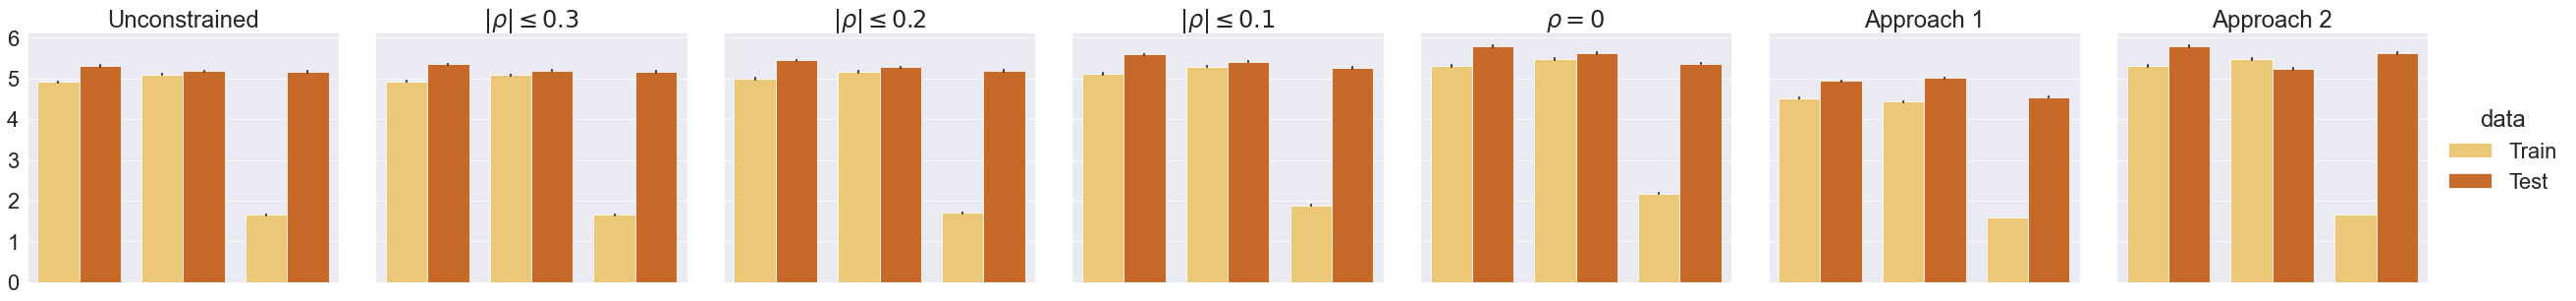

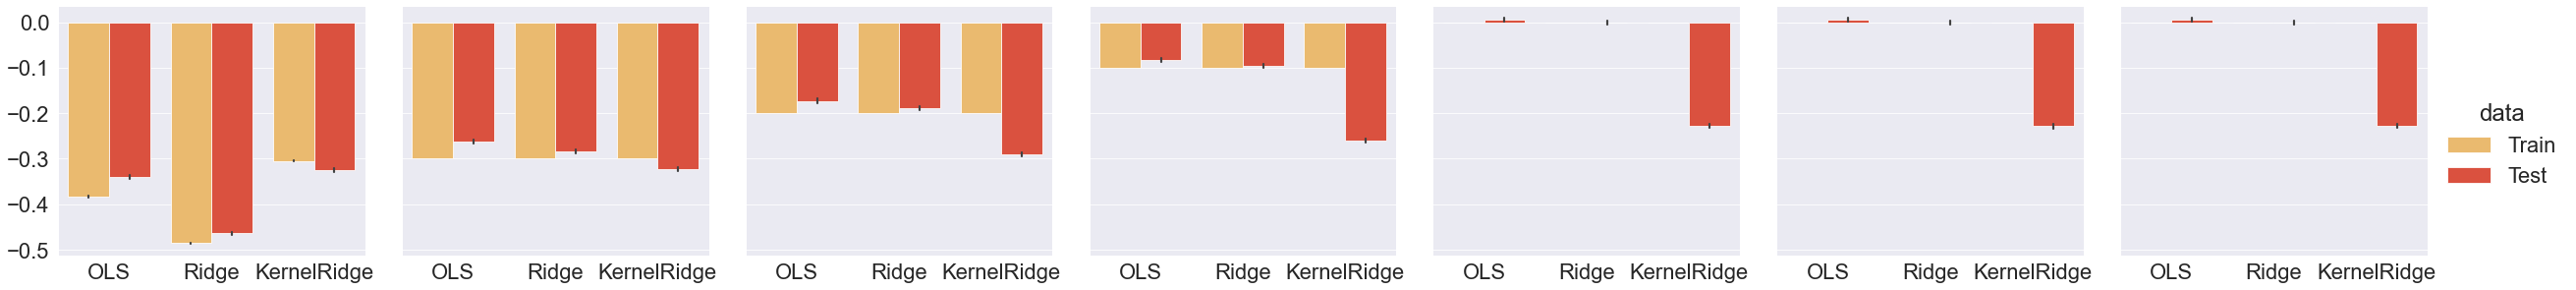

In [107]:
pal = "YlOrBr"
pal2= "YlOrRd"
with sns.plotting_context("paper", font_scale=2.5):  # notebook paper slides
    sns.set_style("darkgrid")
    
    # MSE
    g = sns.catplot(x="model", y="MAE",
                    hue="data", col="constraint",
                    data=df_mae,
                    orient="v", height=5, aspect=1, palette=pal,
                    kind="bar")
    g.set_titles("{col_name}")
    g.set_axis_labels("","")
#     g.set_axis_labels("")
    g.set_xticklabels("")
#     g.set_yticklabels("")
    plt.savefig('Fig_PAC_Results_MAE_train_test.png', dpi=200)
    
    # ADC
    sns.set_style("darkgrid")
    g = sns.catplot(x="model", y="ADC",
                    hue="data", col="constraint",
                    data=df_corr, 
                    orient="v", height=5, aspect=1, palette=pal2,
                    kind="bar")
    g.set_titles("")
    g.set_axis_labels("","")
#     g.set_yticklabels("")
    plt.savefig('Fig_PAC_Results_ADC_train_test.png', dpi=200)

In [108]:
# MAE: Pivot Table with MEAN and STD
pv = pd.pivot_table(df_mae, values='MAE', columns=['model'], index=('data', 'constraint',), \
        aggfunc=np.mean).round(2)
pv_std = pd.pivot_table(df_mae, values='MAE', columns=['model'], index=('data', 'constraint',), \
        aggfunc=np.std).round(2)                                    

In [109]:
# MAE: combine as "mean +- std"
pv_comb = pv.astype('string').apply(lambda x: x + r' $\pm$ ') + pv_std.astype('string')
pv_comb

model                                 OLS            Ridge      KernelRidge
data  constraint                                                           
Train Unconstrained       4.91 $\pm$ 0.09   5.1 $\pm$ 0.08  1.65 $\pm$ 0.04
      $|\rho|\, ≤\, 0.3$  4.93 $\pm$ 0.09  5.08 $\pm$ 0.09  1.65 $\pm$ 0.03
      $|\rho|\, ≤\, 0.2$    5.0 $\pm$ 0.1   5.16 $\pm$ 0.1   1.7 $\pm$ 0.04
      $|\rho|\, ≤\, 0.1$   5.12 $\pm$ 0.1   5.29 $\pm$ 0.1  1.89 $\pm$ 0.05
      $\rho=0$             5.3 $\pm$ 0.11  5.48 $\pm$ 0.11  2.17 $\pm$ 0.06
      Approach 1          4.52 $\pm$ 0.08  4.43 $\pm$ 0.07  1.59 $\pm$ 0.03
      Approach 2           5.3 $\pm$ 0.11  5.48 $\pm$ 0.11  1.67 $\pm$ 0.04
Test  Unconstrained       5.31 $\pm$ 0.09  5.18 $\pm$ 0.06  5.16 $\pm$ 0.09
      $|\rho|\, ≤\, 0.3$  5.35 $\pm$ 0.09  5.19 $\pm$ 0.07  5.16 $\pm$ 0.09
      $|\rho|\, ≤\, 0.2$   5.44 $\pm$ 0.1  5.27 $\pm$ 0.07  5.19 $\pm$ 0.09
      $|\rho|\, ≤\, 0.1$   5.59 $\pm$ 0.1  5.42 $\pm$ 0.08   5.26 $\pm$ 0.1
      $\rho=0$            5.79 $\pm$ 0.11  5.62 $\pm$ 0.09  5.37 $\pm$ 0.11
      Approach 1          4.94 $\pm$ 0.09  5.01 $\pm$ 0.09  4.54 $\pm$ 0.07
      Approach 2          5.79 $\pm$ 0.11  5.23 $\pm$ 0.09  5.62 $\pm$ 0.09

In [110]:
print(pv_comb.to_latex())

\begin{tabular}{lllll}
\toprule
     & model &              OLS &            Ridge &      KernelRidge \\
data & constraint &                  &                  &                  \\
\midrule
Train & Unconstrained &  4.91 \$\textbackslash pm\$ 0.09 &   5.1 \$\textbackslash pm\$ 0.08 &  1.65 \$\textbackslash pm\$ 0.04 \\
     & \$|\textbackslash rho|\textbackslash , ≤\textbackslash , 0.3\$ &  4.93 \$\textbackslash pm\$ 0.09 &  5.08 \$\textbackslash pm\$ 0.09 &  1.65 \$\textbackslash pm\$ 0.03 \\
     & \$|\textbackslash rho|\textbackslash , ≤\textbackslash , 0.2\$ &    5.0 \$\textbackslash pm\$ 0.1 &   5.16 \$\textbackslash pm\$ 0.1 &   1.7 \$\textbackslash pm\$ 0.04 \\
     & \$|\textbackslash rho|\textbackslash , ≤\textbackslash , 0.1\$ &   5.12 \$\textbackslash pm\$ 0.1 &   5.29 \$\textbackslash pm\$ 0.1 &  1.89 \$\textbackslash pm\$ 0.05 \\
     & \$\textbackslash rho=0\$ &   5.3 \$\textbackslash pm\$ 0.11 &  5.48 \$\textbackslash pm\$ 0.11 &  2.17 \$\textbackslash pm\$ 0.06 \\
    

In [111]:
# MAE: Pivot Table with MEAN and STD
pv = pd.pivot_table(df_corr, values='ADC', columns=['model'], index=('data', 'constraint',), \
        aggfunc=np.mean).round(3)
pv_std = pd.pivot_table(df_corr, values='ADC', columns=['model'], index=('data', 'constraint',), \
        aggfunc=np.std).round(3)                                    

In [112]:
# MAE: combine as "mean +- std"
pv_comb = pv.astype('string').apply(lambda x: x + r' $\pm$ ') + pv_std.astype('string')
pv_comb

model                                    OLS               Ridge  \
data  constraint                                                   
Train Unconstrained       -0.384 $\pm$ 0.007  -0.486 $\pm$ 0.007   
      $|\rho|\, ≤\, 0.3$      -0.3 $\pm$ 0.0      -0.3 $\pm$ 0.0   
      $|\rho|\, ≤\, 0.2$      -0.2 $\pm$ 0.0      -0.2 $\pm$ 0.0   
      $|\rho|\, ≤\, 0.1$      -0.1 $\pm$ 0.0      -0.1 $\pm$ 0.0   
      $\rho=0$                -0.0 $\pm$ 0.0      -0.0 $\pm$ 0.0   
      Approach 1              -0.0 $\pm$ 0.0      -0.0 $\pm$ 0.0   
      Approach 2               0.0 $\pm$ 0.0      -0.0 $\pm$ 0.0   
Test  Unconstrained       -0.341 $\pm$ 0.021  -0.464 $\pm$ 0.018   
      $|\rho|\, ≤\, 0.3$  -0.263 $\pm$ 0.021  -0.284 $\pm$ 0.021   
      $|\rho|\, ≤\, 0.2$  -0.173 $\pm$ 0.022   -0.19 $\pm$ 0.022   
      $|\rho|\, ≤\, 0.1$  -0.083 $\pm$ 0.023  -0.095 $\pm$ 0.022   
      $\rho=0$             0.005 $\pm$ 0.023  -0.001 $\pm$ 0.022   
      Approach 1           0.005 $\pm$ 0.023  -0.001 $\pm$ 0.022   
      Approach 2           0.005 $\pm$ 0.023  -0.001 $\pm$ 0.022   

model                            KernelRidge  
data  constraint                              
Train Unconstrained       -0.305 $\pm$ 0.006  
      $|\rho|\, ≤\, 0.3$  -0.299 $\pm$ 0.002  
      $|\rho|\, ≤\, 0.2$      -0.2 $\pm$ 0.0  
      $|\rho|\, ≤\, 0.1$      -0.1 $\pm$ 0.0  
      $\rho=0$                 0.0 $\pm$ 0.0  
      Approach 1              -0.0 $\pm$ 0.0  
      Approach 2              -0.0 $\pm$ 0.0  
Test  Unconstrained       -0.325 $\pm$ 0.022  
      $|\rho|\, ≤\, 0.3$  -0.324 $\pm$ 0.023  
      $|\rho|\, ≤\, 0.2$  -0.291 $\pm$ 0.023  
      $|\rho|\, ≤\, 0.1$   -0.26 $\pm$ 0.024  
      $\rho=0$            -0.228 $\pm$ 0.024  
      Approach 1          -0.228 $\pm$ 0.024  
      Approach 2          -0.228 $\pm$ 0.024

In [ ]:
print(pv_comb.to_latex())

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
print(slope, intercept)

In [ ]:
with sns.plotting_context("paper", font_scale=2.5):  # notebook paper slides
    sns.set_style("darkgrid")
    g = sns.catplot(x="model", y="Time",
                    hue="data", col="constraint",
                    data=df_time,
                    orient="v", height=5, aspect=1.2, palette="YlOrBr",
                    kind="bar") #, dodge=False, cut=1, bw=3.2)
    g.set_titles("{col_name}")

In [ ]:
with sns.plotting_context("paper", font_scale=2.5):  # notebook paper slides
    sns.set_style("darkgrid")
    g = sns.catplot(x="model", y="ADC",
                    hue="data", col="constraint",
                    data=df_corr,
                    orient="v", height=5, aspect=1.2, palette="YlOrBr",
                    kind="box")

### Present timing results as pivot table

In [113]:
# bring categories in right order
df_time['constraint'] = df_time['constraint'].astype('category').cat.reorder_categories(constraints)
df_time['model'] = df_time['model'].astype('category').cat.reorder_categories(('OLS', 'Ridge', 'KernelRidge'))
df_time['data'] = df_time['data'].astype('category').cat.reorder_categories(('Train', 'Test'))

In [114]:
pd.pivot_table(df_time, values='TimeMix', columns='model', index=('data', 'constraint',), \
        aggfunc=np.mean)

model                          OLS      Ridge  KernelRidge
data  constraint                                          
Train Unconstrained       7.791035  81.838586    16.693250
      $\rho=0$            8.524435  97.259358    25.882180
      $|\rho|\, ≤\, 0.1$  8.579165  98.135907    25.912585
      $|\rho|\, ≤\, 0.2$  8.563815  97.838941    25.946602
      $|\rho|\, ≤\, 0.3$  8.582997  98.135050    25.928701
      Approach 1          8.757502  82.921421    16.842694
      Approach 2          8.839446  83.080956    16.873506
Test  Unconstrained       0.207723   0.192493     0.031410
      $\rho=0$            0.168608   0.187575     0.031839
      $|\rho|\, ≤\, 0.1$  0.169737   0.189261     0.031636
      $|\rho|\, ≤\, 0.2$  0.169725   0.188490     0.032025
      $|\rho|\, ≤\, 0.3$  0.169689   0.188885     0.031508
      Approach 1          0.169740   0.186718     0.031819
      Approach 2          0.167782   0.184271     0.031706

In [ ]:
# different layout
# MEAN time
pv = pd.pivot_table(df_time, values='TimeMix', columns=('data','model'), index='constraint', \
        aggfunc=np.mean)
pv

In [ ]:
print(pv.to_latex(float_format="%.2f"))

In [ ]:
# STD time
pv_std = pd.pivot_table(df_time, values='TimeMix', columns=('data','model'), index='constraint', \
        aggfunc=np.std)
pv_std

In [ ]:
print(pv_std.to_latex(float_format="%.2f"))

### Statistical analysis of MAE results

1. For each model (Linear, Ridge, Kernel Ridge) and each data (Train, Test) run a regression of MAE on $\rho$.
2. Compare MAE between unconstrained and constrained models using Wilcoxon signed rank test.

In [115]:
df_mae.groupby(['data','model','constraint'])['MAE'].mean()

data   model        constraint        
Train  OLS          Unconstrained         4.910119
                    $|\rho|\, ≤\, 0.3$    4.927971
                    $|\rho|\, ≤\, 0.2$    4.998994
                    $|\rho|\, ≤\, 0.1$    5.122294
                    $\rho=0$              5.304107
                    Approach 1            4.522177
                    Approach 2            5.304107
       Ridge        Unconstrained         5.097077
                    $|\rho|\, ≤\, 0.3$    5.083031
                    $|\rho|\, ≤\, 0.2$    5.159689
                    $|\rho|\, ≤\, 0.1$    5.291078
                    $\rho=0$              5.484167
                    Approach 1            4.427917
                    Approach 2            5.484167
       KernelRidge  Unconstrained         1.651868
                    $|\rho|\, ≤\, 0.3$    1.650568
                    $|\rho|\, ≤\, 0.2$    1.704591
                    $|\rho|\, ≤\, 0.1$    1.888710
                    $\rho=0$              2

In [116]:
import statsmodels.api as sm
from scipy.stats import wilcoxon, ranksums

# remove the unconstrained data and turn rho's into float
# Unconstrained: 300
# Approach 1: 100
# Approach 2: 200
mae = df_mae.copy()
mae['constraint'] = mae['constraint'].astype('category').cat.rename_categories([300, 0.3, 0.2, 0.1, 0, 100, 200]).astype('float')

mae_train = mae[mae['data']=='Train']
mae_test = mae[mae['data']=='Test']

In [117]:
# regression slopes (with p-values) for MAE ~ rho
for mx, model in enumerate(('OLS', 'Ridge', 'KernelRidge')):
    for px, data in enumerate(('Train', 'Test')):
        fit = sm.OLS.from_formula('MAE ~ constraint', data=mae[(mae.constraint < 1)&(mae.model==model)&(mae.data==data)]).fit()
        print(f"{model} {data}: beta={fit.params['constraint']:.2f} p={fit.pvalues['constraint']:.4f}")

OLS Train: beta=-1.25 p=0.0000
OLS Test: beta=-1.48 p=0.0000
Ridge Train: beta=-1.33 p=0.0000
Ridge Test: beta=-1.44 p=0.0000
KernelRidge Train: beta=-1.75 p=0.0000
KernelRidge Test: beta=-0.69 p=0.0000


In [119]:
# Signed-rank tests on test data
print('MAE on Train vs Test data:', wilcoxon(mae[mae['data']=='Train'].MAE, mae[mae['data']=='Test'].MAE))
for mx, model in enumerate(('OLS', 'Ridge', 'KernelRidge')):
    mae_model = mae_test[mae_test['model']==model]
    print('\n', model, '\n----------')
    print(f'Unconstrained vs rho=0:', wilcoxon(mae_model[mae_model['constraint']==300].MAE, \
                                                        mae_model[mae_model['constraint']==0].MAE))
    print(f'Unconstrained vs rho=0.1:', wilcoxon(mae_model[mae_model['constraint']==300].MAE, \
                                                        mae_model[mae_model['constraint']==0.1].MAE))
    print(f'Unconstrained vs rho=0.2:', wilcoxon(mae_model[mae_model['constraint']==300].MAE, \
                                                        mae_model[mae_model['constraint']==0.2].MAE))
    print(f'Unconstrained vs rho=0.3:', wilcoxon(mae_model[mae_model['constraint']==300].MAE, \
                                                        mae_model[mae_model['constraint']==0.3].MAE))
    print(f'Unconstrained vs Approach 1:', wilcoxon(mae_model[mae_model['constraint']==300].MAE, \
                                                        mae_model[mae_model['constraint']==100].MAE))
    print(f'Unconstrained vs Approach 2:', wilcoxon(mae_model[mae_model['constraint']==300].MAE, \
                                                        mae_model[mae_model['constraint']==200].MAE))

MAE on Train vs Test data: WilcoxonResult(statistic=62449.0, pvalue=7.565503048470114e-307)

 OLS 
----------
Unconstrained vs rho=0: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.1: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.2: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.3: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs Approach 1: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs Approach 2: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)

 Ridge 
----------
Unconstrained vs rho=0: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.1: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.2: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.3: WilcoxonResult(statistic=1424.0, pvalue=0.00015334083624479904)
Unco

### Statistical analysis of ADC results

1. For each model (Linear, Ridge, Kernel Ridge) and each data (Train, Test) run a regression of ADC on $\rho$.
2. Compare ADC between unconstrained and constrained models using Wilcoxon signed rank test.

In [141]:
df_corr.groupby(['data','model','constraint'])['ADC'].mean()

data   model        constraint        
Train  OLS          Unconstrained        -3.837888e-01
                    $|\rho|\, ≤\, 0.3$   -3.000000e-01
                    $|\rho|\, ≤\, 0.2$   -2.000000e-01
                    $|\rho|\, ≤\, 0.1$   -1.000000e-01
                    $\rho=0$             -5.877343e-17
                    Approach 1           -1.235490e-17
                    Approach 2            3.612094e-17
       Ridge        Unconstrained        -4.855881e-01
                    $|\rho|\, ≤\, 0.3$   -3.000000e-01
                    $|\rho|\, ≤\, 0.2$   -2.000000e-01
                    $|\rho|\, ≤\, 0.1$   -1.000000e-01
                    $\rho=0$             -9.602089e-17
                    Approach 1           -7.493809e-18
                    Approach 2           -8.201419e-17
       KernelRidge  Unconstrained        -3.047498e-01
                    $|\rho|\, ≤\, 0.3$   -2.994077e-01
                    $|\rho|\, ≤\, 0.2$   -2.000000e-01
                    $|\rho

In [143]:
import statsmodels.api as sm
from scipy.stats import wilcoxon, ranksums

# remove the unconstrained data and turn rho's into float
corr = df_corr.copy()
corr.constraint = corr.constraint.astype('category')
corr['constraint'] = corr['constraint'].astype('category').cat.rename_categories([300, 0.3, 0.2, 0.1, 0, 100, 200]).astype('float')

corr_train = corr[corr['data']=='Train']
corr_test = corr[corr['data']=='Test']

In [145]:
# run regression and print p-value
for mx, model in enumerate(('OLS', 'Ridge', 'KernelRidge')):
    for px, data in enumerate(('Train', 'Test')):
        fit = sm.OLS.from_formula('ADC ~ constraint', data=corr[(corr.constraint!=-1)&(corr.model==model)&(corr.data==data)]).fit()
        print(f"{model} {data}: beta={fit.params['constraint']:.6f} p={fit.pvalues['constraint']:.4f}")

OLS Train: beta=-0.000349 p=0.0000
OLS Test: beta=-0.000320 p=0.0000
Ridge Train: beta=-0.000595 p=0.0000
Ridge Test: beta=-0.000573 p=0.0000
KernelRidge Train: beta=-0.000158 p=0.0002
KernelRidge Test: beta=-0.000052 p=0.0011


In [148]:
# Signed-rank tests on test data
print('ADC on Train vs Test data:', wilcoxon(corr_train.ADC, corr_test.ADC))
for mx, model in enumerate(('OLS', 'Ridge', 'KernelRidge')):
    corr_model = corr_test[corr_test['model']==model]
    print('\n', model, '\n----------')
    print(f'Unconstrained vs rho=0:', wilcoxon(corr_model[corr_model['constraint']==300].ADC, \
                                                        corr_model[corr_model['constraint']==0].ADC))
    print(f'Unconstrained vs rho=0.1:', wilcoxon(corr_model[corr_model['constraint']==300].ADC, \
                                                        corr_model[corr_model['constraint']==0.1].ADC))
    print(f'Unconstrained vs rho=0.2:', wilcoxon(corr_model[corr_model['constraint']==300].ADC, \
                                                        corr_model[corr_model['constraint']==0.2].ADC))
    print(f'Unconstrained vs rho=0.3:', wilcoxon(corr_model[corr_model['constraint']==300].ADC, \
                                                        corr_model[corr_model['constraint']==0.3].ADC))
    print(f'Unconstrained vs Approach 1:', wilcoxon(mae_model[mae_model['constraint']==300].MAE, \
                                                        mae_model[mae_model['constraint']==100].MAE))
    print(f'Unconstrained vs Approach 2:', wilcoxon(mae_model[mae_model['constraint']==300].MAE, \
                                                        mae_model[mae_model['constraint']==200].MAE))

ADC on Train vs Test data: WilcoxonResult(statistic=877894.0, pvalue=5.44818764766856e-16)

 OLS 
----------
Unconstrained vs rho=0: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.1: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.2: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.3: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs Approach 1: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs Approach 2: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)

 Ridge 
----------
Unconstrained vs rho=0: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.1: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.2: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.3: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstra

<a id="results_tradeoff"></a>
## ADC-MAE tradeoff
[back to top](#top)

Results of the `run_ADC_MAE_tradeoff.py` analysis.

In [92]:
n_iterations = 100

# data dimensions:
resultsdir = '/Users/matthiastreder/data/pac2019/results/'
# iterations x constraints (unconstrained,zero,bounded) x models (LinReg,ridge,KernelRidge) x Train/Test(Predict) phase
mae, corrs, rho = ft.load_pickle(resultsdir + 'roc_curve_pac2019_train_test.pickle')
# mae, corrs, rho, n_iterations = ft.load_pickle(resultsdir + 'roc_curve_pac2019.pickle')


In [93]:
col_OLS = 'darkslateblue'
col_Ridge = 'darkorange'
col_KR1 = 'limegreen'
col_KR2 = 'darkgreen'
model_cols = [col_OLS, col_Ridge, col_KR1]

In [94]:
# convert ndarray into Pandas dataframes
df_m = []
df_c = []
for cx, rhoval in enumerate(rho):
    for mx, model in enumerate(('OLS', 'Ridge', 'KernelRidge')):
        for px, data in enumerate(('Train', 'Test')):
            
            tmp_m = pd.DataFrame({'MAE':mae[:, cx, mx, px]})
            tmp_c = pd.DataFrame({'ADC':-corrs[:, cx, mx, px]})

            tmp_m['rho'] = tmp_c['rho'] = rhoval
            tmp_m['model'] = tmp_c['model'] = model
            tmp_m['data'] = tmp_c['data'] = data
            tmp_m['iteration'] = tmp_c['iteration'] = range(n_iterations)

            df_m.append(tmp_m)
            df_c.append(tmp_c)

df_mae = pd.concat(df_m, axis=0)
df_corr = pd.concat(df_c, axis=0)

df_mae.sort_values(by=['rho', 'iteration'], inplace=True)

df_mae = df_mae.rename(columns={'rho':r'$\rho$'})
df_corr = df_corr.rename(columns={'rho':r'$\rho$'})

In [95]:
# merge MAE and ADC 
df = pd.merge(df_mae, df_corr, how='inner', on=['model','data','iteration',r'$\rho$']) 

In [96]:
df['ADC'] = (df['ADC']/2).round(2) * 2

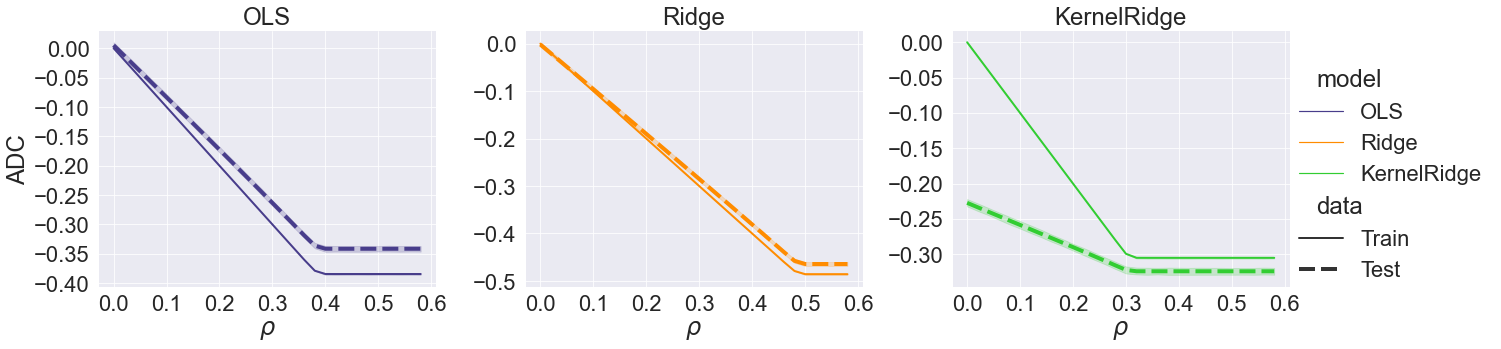

In [97]:
# ADC
with sns.plotting_context("paper", font_scale=2.5):  # notebook paper slides
    sns.set_style("darkgrid")
    g = sns.relplot(x=r'$\rho$', y="ADC",
                    hue="model", style='data',  size='data', col="model", # row='data',
                    kind='line', facet_kws={'sharey': False, 'sharex': True},
                    data=df_corr[df_corr[r'$\rho$']<0.6],
                    sizes= (4, 2),
                    height=5, aspect=1.2, palette=model_cols) #, dodge=False, cut=1, bw=3.2)
#     g.set_titles("{col_name} ({row_name} )")
    g.set_titles("{col_name}")
    plt.savefig('Fig_ROC_curve_CORR.png', dpi=200)

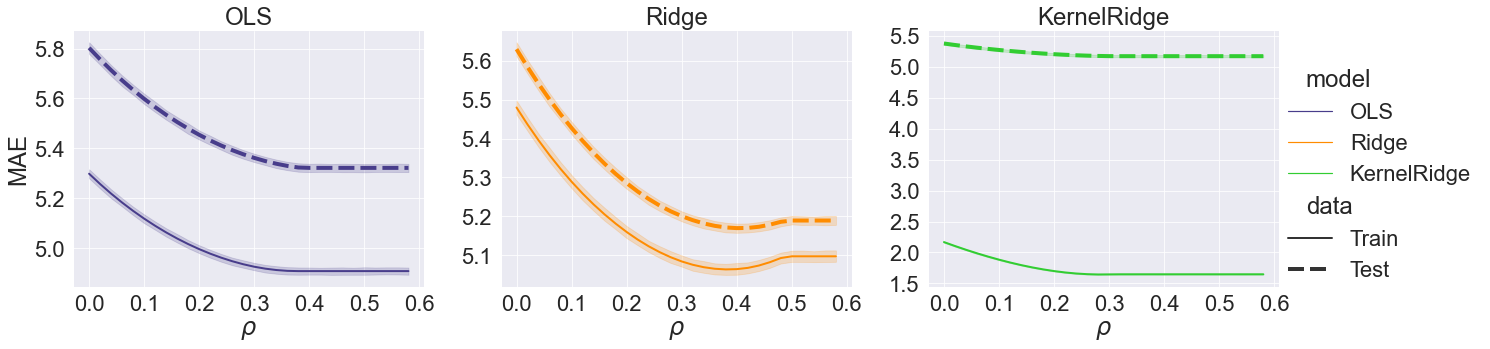

In [98]:
# MAE
with sns.plotting_context("paper", font_scale=2.5):  # notebook paper slides
    sns.set_style("darkgrid")
    g = sns.relplot(x=r"$\rho$", y="MAE",
                    hue="model", style='data', size='data', col="model", #row='data',
                    kind='line', facet_kws={'sharey': False, 'sharex': True},
                    data=df_mae[(df_mae[r'$\rho$']<0.6)],
#                     data=df_mae[(df_mae[r'$\rho$']<0.6) & (df_mae['data']=='Test')],
                    sizes= (4, 2),
                    height=5, aspect=1.2, palette=model_cols) #, dodge=False, cut=1, bw=3.2)
    g.set_titles("{col_name}")
    plt.savefig('Fig_ROC_curve_MAE.png', dpi=200)

In [100]:
df

,MAE,$\rho$,model,data,iteration,ADC
0,5.401278,0.0,OLS,Train,0,-0.00
1,5.888050,0.0,OLS,Test,0,0.02
2,5.593620,0.0,Ridge,Train,0,0.00
3,5.708092,0.0,Ridge,Test,0,0.02
4,2.201616,0.0,KernelRidge,Train,0,0.00
...,...,...,...,...,...,...
30595,5.369503,1.0,OLS,Test,99,-0.32
30596,5.231925,1.0,Ridge,Train,99,-0.48
30597,5.297603,1.0,Ridge,Test,99,-0.44
30598,1.715347,1.0,KernelRidge,Train,99,-0.30


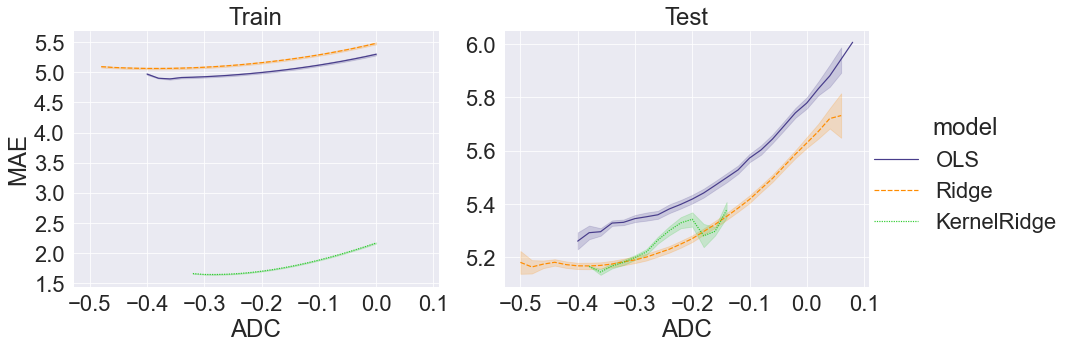

In [102]:
# MAE + ADC
with sns.plotting_context("paper", font_scale=2.5):  # notebook paper slides
    sns.set_style("darkgrid")
    g = sns.relplot(x="ADC", y="MAE",
                    hue="model", style='model', col="data",
                    kind='line', facet_kws={'sharey': False, 'sharex': True},
                    data=df[df[r'$\rho$']<0.5],
                    height=5, aspect=1.2, palette=model_cols) #, dodge=False, cut=1, bw=3.2)
    g.set_titles("{col_name}")

In [ ]:
linreg = ccr.LinearRegression
# ridge = ccr.Ridge
# tune_Ridge = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10]}
# ridge = GridSearchCV(ccr.Ridge(), param_grid=tune_Ridge, scoring='neg_mean_squared_error')

n=0
adc_roc(ridge, correlation_bounds, X_train, X_test, y_train, y_test, alpha=1)
# adc_roc(linreg, correlation_bounds, X_train, X_test, y_train, y_test)

In [ ]:
plt.plot(correlation_bounds, mae[0,:,0,0])
# plt.plot(correlation_bounds, mae[0,:,0,1])
plt.grid()
plt.xlabel(r'$\rho$'); plt.ylabel('MAE')
plt.legend(('Train','Test'))

In [ ]:
plt.plot(correlation_bounds, corrs[0,:,0,0])
plt.plot(correlation_bounds, corrs[0,:,0,1])
plt.xlabel(r'$\rho$')
plt.ylabel('ADC')
plt.grid()
plt.legend(('Train','Test'))

<a id="other"></a>
# Other/old
[back to top](#top)

<a id="statsmodels"></a>
## Statsmodels
[back to top](#top)

In [ ]:
from statsmodels.regression.linear_model import OLS, OLSResults, RegressionResultsWrapper

class OLSCC(OLS):
    def __init__(self, endog, exog=None, missing='none', hasconst=None, rho=0,
                 **kwargs):
        super(OLSCC, self).__init__(endog, exog, missing=missing,
                                  hasconst=hasconst, **kwargs)
        if "weights" in self._init_keys:
            self._init_keys.remove("weights")
        self.rho = rho
        
    def fit(self, method="pinv", cov_type='nonrobust', cov_kwds=None,
            use_t=None, **kwargs):
        # see fit method in class RegressionModel in:
        # https://github.com/statsmodels/statsmodels/blob/master/statsmodels/regression/linear_model.py
        results = super().fit(method, cov_type, cov_kwds, use_t, **kwargs)

        if self.rho is not None:
            # scale beta to fulfill correlation constraint
            X, y = self.exog, self.endog
            beta = results.params
            
            # check whether there is an intercept
            intercept_ix = None
            if np.all(X[:, 0] == 1):
                intercept_ix = 0
            elif np.all(X[:, -1] == 1):
                intercept_ix = X.shape[1]
            elif not(np.all(np.isclose(y.mean(), 0)) and np.all(np.isclose(X.mean(axis=0), 0))):
                raise ValueError('endog must contain an intercept term or predictors and responses need to be centered')

            yc = y - y.mean()
            yhat = results.fittedvalues - results.fittedvalues.mean()
            if self.rho == 0:
                # calculate correction factor a
                a = yc.dot(yc) / yhat.dot(yhat) 
            else:
                # set corr(y, y - yhat) to rho or -rho
                y2 = yc.dot(yc)
                yhat2 = yhat.dot(yhat)
                yyhat = yc.dot(yhat)
                rho2 = self.rho**2
                c = yyhat**2 - rho2*y2*yhat2

                # since we use a square to solve for a we get two solutions
                # one gives us corr(y,e) = rho, the other corr(y,e) = -rho
                a1 = y2 * yyhat * (1-rho2)/c - y2/c * np.sqrt( rho2 * (1-rho2) * (y2*yhat2 - yyhat**2))
                a2 = y2 * yyhat * (1-rho2)/c + y2/c * np.sqrt( rho2 * (1-rho2) * (y2*yhat2 - yyhat**2))
                a = a1

            # applt a to non-intercept elements of beta
            beta_ix = np.setdiff1d(np.array(range(X.shape[1]), dtype=np.int), intercept_ix)
            beta[beta_ix] *= a

            # fix intercept
            if intercept_ix is not None:
                mx = X[:, beta_ix].mean(axis=0)
                beta[intercept_ix] = y.mean() - mx.dot(beta[beta_ix])

            lfit = OLSResults(
                self, beta,
                normalized_cov_params=self.normalized_cov_params,
                cov_type=cov_type, cov_kwds=cov_kwds, use_t=use_t)
            
            results = RegressionResultsWrapper(lfit)
            results.a = a
            
        return results

In [ ]:
model = sm.OLS(y, X).fit()
model_cc = OLSCC(y, X, rho=0.01).fit()

In [ ]:
model.summary()